In [1]:
%load_ext autoreload
%autoreload 2
from utils.utils import *
from utils.utils_train import *
from utils.utils_imports import *

In [2]:
# Load SBERT Embeddings
queries, query_embeddings, product_embeddings = load_raw_queries()

# load ids_toys from disk
with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    print(f"len(ids_toys): {len(ids_toys)}")
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]

# Assemble qb & xb input embeddings
qb = torch.stack([torch.tensor(query_embeddings[_id]) for _id in ids_present])
xb = torch.tensor(np.array([product_embeddings[_id] for _id in ids_present]))

# Split Dataset into Train and Test
(qb_train, qb_test), (xb_train, xb_test), (idx_train, idx_test) = shuffle_and_split(qb, xb, split=0.8, seed=12)
print(f'len(qb_train): {len(qb_train)}')
print(f'len(qb_test): {len(qb_train)}')

# Two-Tower Pytorch Model
d = qb_train.shape[-1]
list_recall3 = []
list_test_epochs = []

# Initialize the network
model = TwoTowerNetwork(d, hidden_dim=d)


loaded (queries, query_embeddings, product_embeddings) from  output/raw_queries.pkl
len(ids_toys): 84373
len(qb_train): 20560
len(qb_test): 20560
dropout         : 0.1
learning_rate   : 0.001
label_smoothing : 0.35
batch_size      : 1024
eval_iter       : 1

TwoTowerNetwork(
  (qb_tower): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (xb_tower): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=1536, out_features=768, bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=768, out_features=1, bias=False)
  )
)
num_params:2.36 million 


In [ ]:
%%time
## TRAIN
# Hyperparameters
num_epochs = 1

for i in range(200):

    # reshuffle the trainset at beginning of each epoch
    (qb_train, _), (xb_train, _), (_) = shuffle_and_split(qb_train, xb_train, split=1)
    
    # train for 1 epoch
    model.fit(qb_train, xb_train)

    # write output embeddings to use for eval
    write_output_embeddings(model, qb_test, xb_test) 

    # run eval
    os.system('cd utils && python3 utils_infer.py')

    # read recall@3 metric written to json file
    with open('output/recall3.json', 'r') as file:
        recall3 = json.load(file)['recall3']

    # monitor metrics to plot recall.
    list_test_epochs.append(model.epochs[-1])
    list_recall3.append(recall3) 

    if (i+1) % 1 == 0:
        model.plot(qb_train, list_test_epochs, list_recall3) 

out of fused_trainset: (1024, 1024, 768) (1024,) 7.33 sec
forward pass b:0 (torch.Size([1024, 1024, 768])): Runtime: 0 min 26 sec


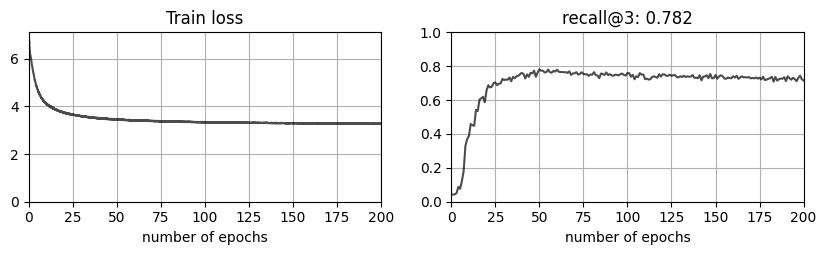

In [4]:
model.plot(qb_train, list_test_epochs, list_recall3)


In [ ]:
# TODO:
# 1. Incorporate a learning_rate scheduler
# 2. print the top 3 results for hits. 
# 3. naive baseline on SBERT embeddings recall@3 = 0.745
# 4. 

In [10]:
write_output_embeddings(model, qb_test, xb_test) 
os.system('cd utils && python3 utils_infer.py')


### The End

In [ ]:
# Load queries, ids_toys, ids_present
with open('output/raw_queries.pkl', 'rb') as file:
    queries, _, _ = pickle.load(file)

with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]


In [5]:
top_ids = [ids_present[idx_test[i]] for i in I[0]]
names = [info[_id]['name'] for _id in top_ids]
details = [info[_id]['details'] for _id in top_ids]
description = [info[_id]['description'] for _id in top_ids]
queries[ids_present[idx_test[0]]]

"I need to buy a Super-duper Tutu/Cape/Mask set in size 4-6 for my 4-6-year-old. It's a 3-piece set perfect for little Superheroines and Rock Stars!"